In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn

import time, pathlib, os

## 2D dataset

In [2]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
# X1 = np.linspace(-2.5, 0, num_points)
X2 = np.linspace(-2, 4, num_points)
# X2 = np.linspace(-2, 2, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

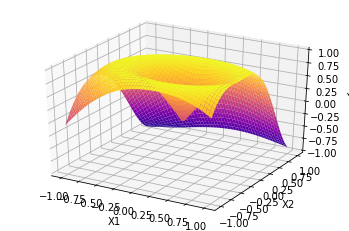

In [3]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1
# Y = -Y

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [4]:
network_seeds = [147, 258, 369]

## Gradient Clipped Lipschitz Penalty (Ours)

In [5]:
class LipschitzNet(nn.Module):
    
    def __init__(self, net, K=1., lamda=1.):
        super().__init__()
        
        self.net = net
        self.lamda = lamda
        self.X = None
        
        self.Y = None
        self.dydx = None
        self.K = K
        
        self.gp = 0
        self.gclipper = torch.Tensor([999])
        
    def forward(self, x):
        self.X = torch.autograd.Variable(x, requires_grad=True)
        
        self.Y = self.net(self.X)
        y = self.Y+0.
        y.register_hook(self.scale_gradient_back)
        return y
    
    def scale_gradient_back(self, grad):
#         print("Old", grad.shape)
#         grad = torch.min(torch.max(grad, -self.gclipper), self.gclipper)
#         print("New", grad.shape)
#         return grad
#         return torch.min(torch.max(grad, -self.gclipper), self.gclipper)
        return torch.minimum(torch.maximum(grad, -self.gclipper), self.gclipper)

    
    def get_dydx(self):
        self.dydx = torch.autograd.grad(outputs=self.Y, inputs=self.X,
                                    grad_outputs=torch.ones_like(self.Y),
                                    only_inputs=True, retain_graph=True, create_graph=True)[0]
        return self.dydx
    
    def get_gradient_penalty(self):
#         m = self.dydx.shape[0]
        dydx_norm = torch.norm(self.dydx, p=2, dim=1, keepdim=True)
#         self.cond = -(torch.abs(dydx_norm/self.K) -1.)
        self.cond = -dydx_norm/self.K +1.
        
        a=-20
        intolerables = torch.log(torch.exp(a*(self.cond-0.1))+1)/a
        
#         dydx_norm = torch.norm(self.dydx.data, p=2, dim=1, keepdim=True)
        
        self.gp = 0.5*((intolerables*5)**2).mean()*self.lamda
        
#         self.gp = 0.5*(intolerables**2).sum()*self.lamda
        
#         intolerables = torch.min(self.cond-1e-1, torch.zeros_like(self.cond))
#         self.gp = 0.5*(intolerables**2).mean()*self.lamda
#         self.gp = torch.abs(intolerables).mean()*self.lamda
#         self.gp = 0.5*(torch.abs(intolerables)+intolerables**2).mean()*self.lamda

        return self.gp
    
    ##
    def get_gradient_clipper(self):
        with torch.no_grad():
            cond = self.cond.data
            linear_mask = cond>0.14845
#             print(dydx.shape, linear_mask.shape)
            a = 20.
            gclipper = -((1.05*(cond-1))**4)+1
            gclipper = torch.log(torch.exp(a*gclipper)+1)/a
#             print(gclipper.shape)
            gc2 = 3*cond-0.0844560006
#             print(gc2.shape)
            gclipper[linear_mask] = gc2[linear_mask]
#             print(gclipper.shape)
#             gclipper = torch.clamp(gclipper, min=0.01)
            self.gclipper = gclipper
            
        return self.gclipper

    def MSE_loss(self, diff):
        return 0.5*(diff**2).mean()
    
    def compute_penalty_and_clipper(self):
        self.get_dydx()
        self.get_gradient_penalty()
        self.get_gradient_clipper()
        return

In [6]:
# torch.norm(torch.randn(2,5), dim=1)
# torch.randn(5).unsqueeze(0).shape

In [7]:
# actf = nn.LeakyReLU
actf = nn.ELU

# net_lips = nn.Sequential(nn.Linear(2,20),
#                    actf(),
#                    nn.Linear(20,1))

torch.manual_seed(network_seed)

net_lips = nn.Sequential(nn.Linear(2,10),
                         actf(),
                         nn.Linear(10,10),
                         actf(),
                         nn.Linear(10,1))

lipsNet = LipschitzNet(net_lips, K=1, lamda=3.)

optimizer = torch.optim.Adam(lipsNet.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [8]:
# yout = lcNet(xx)
# lcNet.compute_penalty_and_scaler()
# lcNet.MSE_loss(yout-yy).backward()

Epoch: 0, Loss:1.0060815811157227, MinCond: 0.794582724571228, MaxK: 0.20541724562644958, MinK: 0.09743992239236832


Epoch: 100, Loss:0.11524844914674759, MinCond: 0.12001055479049683, MaxK: 0.8799894452095032, MinK: 0.2922526001930237


Epoch: 200, Loss:0.10627058148384094, MinCond: 0.11362391710281372, MaxK: 0.8863760828971863, MinK: 0.07573695480823517


Epoch: 300, Loss:0.10518527776002884, MinCond: 0.12044298648834229, MaxK: 0.8795570135116577, MinK: 0.0017257645959034562


Epoch: 400, Loss:0.1047043427824974, MinCond: 0.12425076961517334, MaxK: 0.8757492303848267, MinK: 0.002013871446251869


Epoch: 500, Loss:0.10403473675251007, MinCond: 0.12365174293518066, MaxK: 0.8763482570648193, MinK: 0.05577247962355614


Epoch: 600, Loss:0.1026337593793869, MinCond: 0.11720550060272217, MaxK: 0.8827944993972778, MinK: 0.07661912590265274


Epoch: 700, Loss:0.10058537870645523, MinCond: 0.1038636565208435, MaxK: 0.8961363434791565, MinK: 0.008485681377351284


Epoch: 800, Loss:0.098602831

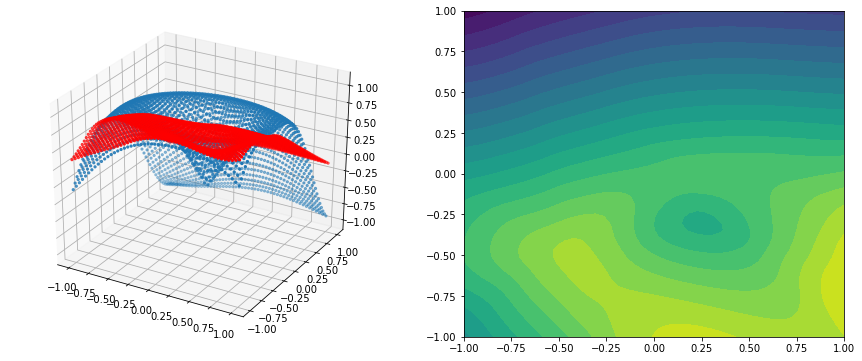

In [9]:
%matplotlib tk

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)
# ax.view_init(28,20)

per_step_time = []

for epoch in range(5000):
    start = time.time()
    
    yout = lipsNet(xx)    
    lipsNet.compute_penalty_and_clipper()
    loss = criterion(yout, yy) + lipsNet.gp

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    per_step_time.append(time.time()-start)
   
    if epoch%100 == 0:
        min_val = float(lipsNet.cond.min())
        max_k = float(torch.norm(lipsNet.dydx, p=2, dim=1, keepdim=True).max())
        min_k = float(torch.norm(lipsNet.dydx, p=2, dim=1, keepdim=True).min())
        print(f'Epoch: {epoch}, Loss:{float(loss)}, MinCond: {min_val}, MaxK: {max_k}, MinK: {min_k}')

        ax.clear()
        ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        
        ax2.clear()
        ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
print(np.mean(per_step_time), np.std(per_step_time))

In [10]:
# Epoch: 4300, Loss:0.08726055920124054, MinCond: 0.058685362339019775, MaxK: 0.9413146376609802
np.mean(per_step_time), np.std(per_step_time)

(0.004578222417831421, 0.000765321885925304)

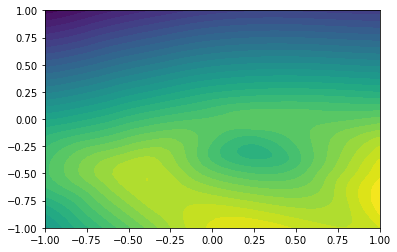

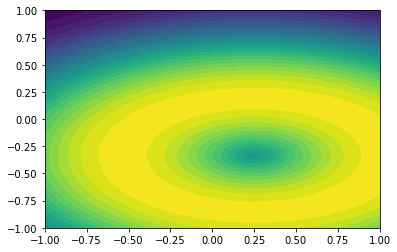

In [11]:
%matplotlib inline

plt.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=30)
plt.show()
plt.contourf(X1, X2, yy.data.numpy().reshape(Y.shape), levels=30)
plt.show()

In [12]:
# lipsNet.K = 2

In [13]:
# yy = torch.Tensor(Y.reshape(-1,1)/3.)

In [14]:
# yy = torch.Tensor(Y.reshape(-1,1))

In [15]:
# yy = torch.Tensor(Y.reshape(-1,1)*3.)

In [16]:
# yy.min(), yy.max()

## Spectral Norm

In [17]:
# # actf = nn.LeakyReLU
# actf = nn.ELU
# # actf = nn.ReLU

# torch.manual_seed(network_seed)

# net_lips = nn.Sequential(nn.utils.spectral_norm(nn.Linear(2,10)),
#                    actf(),
#                  nn.utils.spectral_norm(nn.Linear(10,10)),
#                    actf(),
#                    nn.utils.spectral_norm(nn.Linear(10,1)))

# ## no clipper and loss used..., just for getting gradient norm.
# snNet = LipschitzNet(net_lips)

# optimizer = torch.optim.Adam(snNet.parameters(), lr=0.01)
# criterion = nn.MSELoss()

In [18]:
# %matplotlib tk

# fig = plt.figure(figsize=(15,6))
# ax = fig.add_subplot(121,projection='3d')
# ax2 = fig.add_subplot(122)

# per_step_time = []

# for epoch in range(5000):
#     start = time.time()
    
#     yout = snNet(xx)
#     loss = criterion(yout, yy)
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
   
#     per_step_time.append(time.time()-start)
    
#     if epoch%100 == 0:
#         yout = snNet(xx)
#         snNet.get_dydx()
        
#         max_k = float(torch.norm(snNet.dydx, p=2, dim=1, keepdim=True).max())
#         min_k = float(torch.norm(snNet.dydx, p=2, dim=1, keepdim=True).min())
#         print(f'Epoch: {epoch}, Loss:{float(loss)}, MaxK: {max_k}, MinK: {min_k}')

#         ax.clear()
#         ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
#         ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        
#         ax2.clear()
#         ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

#         fig.canvas.draw()
#         plt.pause(0.01)
#         print("\n")

In [19]:
# torch.maximum(torch.randn(5, 20), torch.Tensor([-1]))
np.mean(per_step_time), np.std(per_step_time)

(0.004578222417831421, 0.000765321885925304)

In [20]:
## Spectral norm constrains the upper bound to the lipschitz constant. 
## This makes the weight to have maximum of one slope, but when Relu is applied,
## the lipschitz constant is always below 1.
## if one piece of data space (one relu) takes the slope 1, other has to take slope 0. 
## even if other pieces are independent, the lipschitz value is highly reduced than 1.

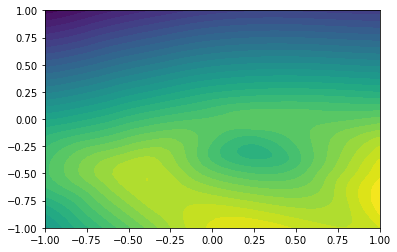

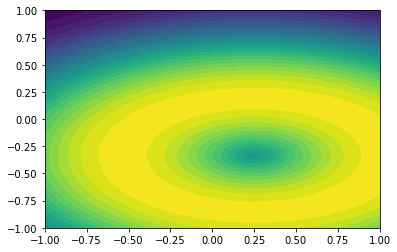

In [21]:
%matplotlib inline

plt.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=30)
plt.show()
plt.contourf(X1, X2, yy.data.numpy().reshape(Y.shape), levels=30)
plt.show()

## Gradient Penalty

In [22]:
class GradientPenaltyNet(nn.Module):
    
    def __init__(self, net, K=1., lamda=1.):
        super().__init__()
        
        self.net = net
        self.lamda = lamda
        self.X = None
        
        self.Y = None
        self.dydx = None
        self.K = K
        
        self.gp = 0
        
    def forward(self, x):
        self.X = torch.autograd.Variable(x, requires_grad=True)
        
        self.Y = self.net(self.X)
        y = self.Y+0.
        return y

    def get_dydx(self):
        self.dydx = torch.autograd.grad(outputs=self.Y, inputs=self.X,
                                    grad_outputs=torch.ones_like(self.Y),
                                    only_inputs=True, retain_graph=True, create_graph=True)[0]
        return self.dydx
    
    def get_gradient_penalty(self):
        dydx_norm = torch.norm(self.dydx, p=2, dim=1, keepdim=True)
        
        self.gp = ((dydx_norm-1)**2).mean()*self.lamda
        return self.gp
    
    def MSE_loss(self, diff):
        return 0.5*(diff**2).mean()
    
    def compute_penalty(self):
        self.get_dydx()
        self.get_gradient_penalty()
        return

In [23]:
# actf = nn.LeakyReLU
actf = nn.ELU

torch.manual_seed(network_seed)
net_lips = nn.Sequential(nn.Linear(2,10),
                         actf(),
                         nn.Linear(10,10),
                         actf(),
                         nn.Linear(10,1))

gpNet = GradientPenaltyNet(net_lips, K=1, lamda=3.)

optimizer = torch.optim.Adam(gpNet.parameters(), lr=0.01)
criterion = nn.MSELoss()

Epoch: 0, Loss:3.081449270248413, MaxK: 0.20541724562644958 MinK: 0.09743992239236832


Epoch: 100, Loss:0.16946373879909515, MaxK: 1.0798273086547852 MinK: 0.8350089192390442


Epoch: 200, Loss:0.1605653464794159, MaxK: 1.0441240072250366 MinK: 0.9237648248672485


Epoch: 300, Loss:0.1593991070985794, MaxK: 1.0371668338775635 MinK: 0.9269824624061584


Epoch: 400, Loss:0.15789106488227844, MaxK: 1.0463241338729858 MinK: 0.9185736179351807


Epoch: 500, Loss:0.15394893288612366, MaxK: 1.0763448476791382 MinK: 0.9035604000091553


Epoch: 600, Loss:0.14774827659130096, MaxK: 1.0797585248947144 MinK: 0.8770791292190552


Epoch: 700, Loss:0.1431628316640854, MaxK: 1.0876644849777222 MinK: 0.8553411364555359


Epoch: 800, Loss:0.14080995321273804, MaxK: 1.121778130531311 MinK: 0.8068324327468872


Epoch: 900, Loss:0.13802272081375122, MaxK: 1.1048866510391235 MinK: 0.7549416422843933


Epoch: 1000, Loss:0.13567988574504852, MaxK: 1.0851802825927734 MinK: 0.7062235474586487


Epoch: 1100, Lo

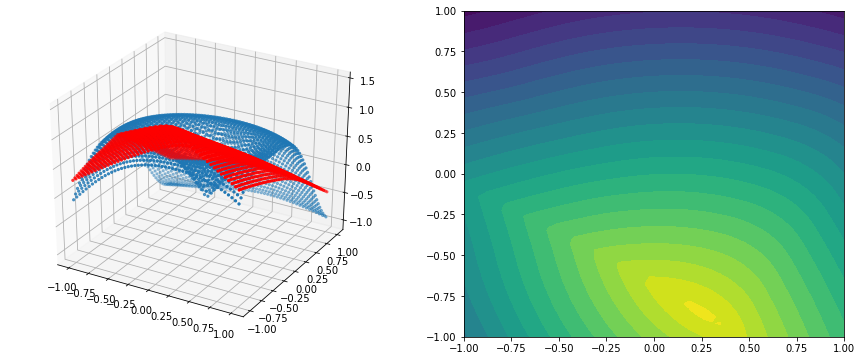

In [24]:
%matplotlib tk

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)


per_step_time = []

for epoch in range(5000):
    start = time.time()
    
    yout = gpNet(xx)    
    gpNet.compute_penalty()
    loss = criterion(yout, yy) + gpNet.gp

    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    per_step_time.append(time.time()-start)
    if epoch%100 == 0:
        allk = torch.norm(gpNet.dydx, p=2, dim=1, keepdim=True)
        max_k = float(allk.max())
        min_k = float(allk.min())
        
        print(f'Epoch: {epoch}, Loss:{float(loss)}, MaxK: {max_k} MinK: {min_k}')

        ax.clear()
        ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        
        ax2.clear()
        ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

In [25]:
np.mean(per_step_time), np.std(per_step_time)

(0.003935760450363159, 0.0005525987044208215)

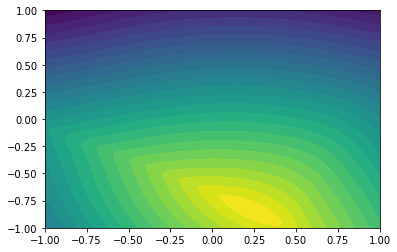

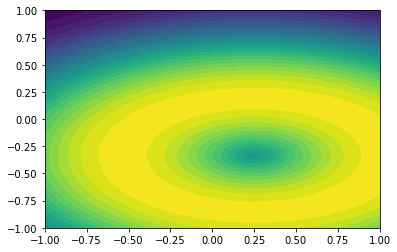

In [26]:
%matplotlib inline

plt.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=30)
plt.show()
plt.contourf(X1, X2, yy.data.numpy().reshape(Y.shape), levels=30)
plt.show()

## Lipschitz Penalty

In [32]:
class LipschitzPenaltyNet(nn.Module):
    
    def __init__(self, net, K=1., lamda=1.):
        super().__init__()
        
        self.net = net
        self.lamda = lamda
        self.X = None
        
        self.Y = None
        self.dydx = None
        self.K = K
        
        self.gp = 0
        
    def forward(self, x):
        self.X = torch.autograd.Variable(x, requires_grad=True)
        
        self.Y = self.net(self.X)
        y = self.Y+0.
        return y

    def get_dydx(self):
        self.dydx = torch.autograd.grad(outputs=self.Y, inputs=self.X,
                                    grad_outputs=torch.ones_like(self.Y),
                                    only_inputs=True, retain_graph=True, create_graph=True)[0]
        return self.dydx
    
    def get_gradient_penalty(self):
        dydx_norm = torch.norm(self.dydx, p=2, dim=1, keepdim=True)
        
        self.gp = ((torch.maximum(dydx_norm-1, torch.Tensor([0])))**2).mean()*self.lamda
#         self.gp = ((dydx_norm-1)**2).mean()*self.lamda
        return self.gp
    
    def MSE_loss(self, diff):
        return 0.5*(diff**2).mean()
    
    def compute_penalty(self):
        self.get_dydx()
        self.get_gradient_penalty()
        return

In [46]:
# actf = nn.LeakyReLU
actf = nn.ELU

torch.manual_seed(258)
net_lips = nn.Sequential(nn.Linear(2,10),
                         actf(),
                         nn.Linear(10,10),
                         actf(),
                         nn.Linear(10,1))

lpNet = LipschitzPenaltyNet(net_lips, K=1, lamda=3.)

optimizer = torch.optim.Adam(lpNet.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [47]:
%matplotlib tk

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)


per_step_time = []



for epoch in range(5000):
    start = time.time()
    
    yout = lpNet(xx)    
    lpNet.compute_penalty()
    loss = criterion(yout, yy) + lpNet.gp

    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    per_step_time.append(time.time()-start)
    
    if epoch%4900 == 0:
        allk = torch.norm(lpNet.dydx, p=2, dim=1, keepdim=True)
        max_k = float(allk.max())
        min_k = float(allk.min())
        
        print(f'Epoch: {epoch}, Loss:{float(loss)}, MaxK: {max_k} MinK: {min_k}')

        ax.clear()
        ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        
        ax2.clear()
        ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:0.46714794635772705, MaxK: 0.08580604940652847 MinK: 0.04806589335203171


Epoch: 4900, Loss:0.0685158371925354, MaxK: 1.1605892181396484 MinK: 0.03964458778500557




In [49]:
np.mean(per_step_time), np.std(per_step_time)

(0.0036550421714782715, 0.0012464696248655498)

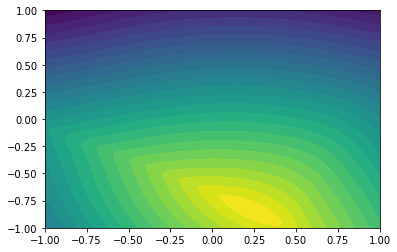

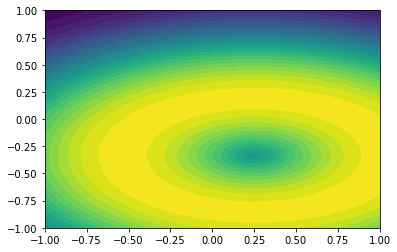

In [31]:
%matplotlib inline

plt.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=30)
plt.show()
plt.contourf(X1, X2, yy.data.numpy().reshape(Y.shape), levels=30)
plt.show()